In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os
import datetime
import plotly as plotly
import plotly.express as px
import plotly.graph_objects as go
from time import process_time
import psutil
import sklearn
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as smf

In [2]:
#Load the street level data from 2015 until October 2021
#Load additional datasets including police district budget, personnel,
#IMD index and the population of a LSOA.

data = pd.read_csv('export.csv') 
funding = pd.read_csv('Funding data.csv')
IMD = pd.read_csv(r'IMD2019.csv', delimiter = ';')
IMD = IMD[['LSOA code','Index of Multiple Deprivation (IMD) Rank','Index of Multiple Deprivation (IMD) Decile']]

#drop columns about e.g. the number of 60-64 year olds in LSOA, not used in our analysis
path = "lsoa pop estimates.xlsx"
lsoa_pop = pd.read_excel(path)
lsoa_pop_refined = lsoa_pop[['LSOA Code','LSOA Name','All Ages']]  
lsoa_pop_refined = lsoa_pop_refined.rename(columns={"LSOA Code": "LSOA code"})

## creating dataframes

In [3]:
#count the number of crimes per LSOA
#resulting columns are interchangable so all but one can be dropped

grouped_per_lsoa = data.groupby(['LSOA code']).count()
grouped_per_lsoa = grouped_per_lsoa[['Unnamed: 0']]
grouped_per_lsoa = grouped_per_lsoa.rename(columns={"Unnamed: 0": "Crimes"})
grouped_per_lsoa = grouped_per_lsoa.reset_index()

In [4]:
#count the number of crimes per police district

per_district = data.groupby('Falls within').count()
per_district = per_district[['Unnamed: 0']]
per_district = per_district.rename(columns={"Unnamed: 0": "Crimes"})
per_district = per_district.reset_index()

In [5]:
#merge the crimes per district with additional information about those districts
#budget is converted to millions of pounds to make the regression coefficient more useful

merged_districts = pd.merge(per_district,funding)
merged_districts = merged_districts.rename(
    columns={"Police Force Name": "Location", "2021 budget":"budget_millions",
            "police officers 2021":"personnel","frontline support":"fsupport",
             "business support":"bsupport"})
merged_districts['budget_millions'] = merged_districts['budget_millions'] / 1000000

In [6]:
#drop the city of london and the metropolitan police service

merged_districts = merged_districts.drop([4, 22])

In [7]:
#due to errors in the data most LSOA's have crimes recorded 
#in a different police district

LSOA_location = data.groupby(['LSOA code', 'Falls within']).count()

In [8]:
LSOA_location = LSOA_location[['Unnamed: 0']]
LSOA_location = LSOA_location.rename(columns={"Unnamed: 0": "Crimes"})

In [48]:
#for every LSOA the entry with the most crimes is correct

LSOA_correct = LSOA_location.copy().reset_index()
LSOA_correct = LSOA_correct.sort_values(by = ['LSOA code','Falls within'])
LSOA_correct

,LSOA code,Falls within,Crimes
0,E01000001,City of London Police,1631
1,E01000001,Metropolitan Police Service,192
2,E01000002,City of London Police,1852
3,E01000002,Metropolitan Police Service,140
4,E01000002,Surrey Police,1
...,...,...,...
63941,E01033766,Merseyside Police,213
63942,E01033766,Metropolitan Police Service,1
63943,E01033767,Merseyside Police,819
63944,E01033768,Merseyside Police,1641


In [49]:
#drop the incorrect columns so that only the true location remains

LSOA_correct = LSOA_correct.drop_duplicates(subset='LSOA code', keep="first")
LSOA_correct = LSOA_correct.reset_index()
LSOA_correct = LSOA_correct[['LSOA code','Falls within','Crimes']]

In [50]:
#add the total number of crimes, including those wrongly placed
#end result is a dataframe with correct information about location and number of crimes

LSOA_correct2 = LSOA_correct.join(grouped_per_lsoa, lsuffix='_caller', rsuffix='_other')
LSOA_correct3 = LSOA_correct2[['LSOA code_caller','Falls within','Crimes_other']]
LSOA_correct3= LSOA_correct3.rename(
    columns={"LSOA code_caller": "LSOA code", "Crimes_other":"Crimes"})
LSOA_correct3

,LSOA code,Falls within,Crimes
0,E01000001,City of London Police,1823
1,E01000002,City of London Police,1994
2,E01000003,City of London Police,472
3,E01000005,City of London Police,4049
4,E01000006,Essex Police,748
...,...,...,...
32835,E01033764,Merseyside Police,5203
32836,E01033765,Merseyside Police,1994
32837,E01033766,Merseyside Police,214
32838,E01033767,Merseyside Police,819


In [51]:
#add to previous dataframe data about deprivation, population 
#and the district the LSOA is in

merged_good = pd.merge(LSOA_correct3, IMD)

In [52]:
merged_good2 = pd.merge(merged_good, funding)

In [53]:
merged_good3 = pd.merge(merged_good2, lsoa_pop_refined)

In [54]:
#compute the crimes per population per LSOA 
merged_good3['Crime per population'] = merged_good3['Crimes'] / merged_good3['All Ages']

In [55]:
#rename columns for the regression model
#remove outliers with a higher crime to inhabitant ratio than two
#convert budget to millions of pounds

merged_good3= merged_good3.rename(
    columns={"Index of Multiple Deprivation (IMD) Decile": "IMD", "All Ages":"LSOApop",
            "police officers 2021":"personnel", "2021 budget":"budget",
            "Index of Multiple Deprivation (IMD) Rank":"IMDrank",
            "frontline support":"fsupport","business support":"bsupport"})
merged_good3 = merged_good3[merged_good3['Crime per population'] < 2]
merged_good3['budget'] = merged_good3['budget'] / 1000000

In [56]:
#separate rename as it didn't work in one go for some reason

merged_good3= merged_good3.rename(columns={"Crime per population": "Crimepop"})

In [57]:
#remove city of london and metropolitan police service from the dataframe

merged_good_no_london = merged_good3[merged_good3['Falls within'] != 'Metropolitan Police Service']
merged_good_no_london = merged_good_no_london[merged_good3['Falls within'] != 'City of London Police']

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


In [58]:
merged_good_no_london.head(5)

,LSOA code,Falls within,Crimes,IMDrank,IMD,budget,population,personnel,frontline,fsupport,bsupport,LSOA Name,LSOApop,Crimepop
126,E01000006,Essex Police,748,14.486,5,330.31,1846700,3415,3079,75,124,Barking and Dagenham 016A,2117,0.353330
127,E01000007,Essex Police,3687,7.256,3,330.31,1846700,3415,3079,75,124,Barking and Dagenham 015A,2704,1.363536
128,E01000009,Essex Police,2364,6.736,3,330.31,1846700,3415,3079,75,124,Barking and Dagenham 016B,1959,1.206738
130,E01000018,Essex Police,910,6.504,2,330.31,1846700,3415,3079,75,124,Barking and Dagenham 009D,1724,0.527842
131,E01000019,Essex Police,921,6.410,2,330.31,1846700,3415,3079,75,124,Barking and Dagenham 023A,1530,0.601961


## Models

In [59]:
#Fit the model on the district level

#model_district = smf.ols('Crimes~budget_millions+population+personnel', merged_districts).fit()
#model_district = smf.ols('Crimes~budget_millions+population+frontline+fsupport+bsupport', merged_districts).fit()
model_district = smf.ols('Crimes~frontline+fsupport+population', merged_districts).fit()


In [60]:
prediction_model_district = model_district.predict(merged_districts)

merged_districts['prediction'] = model_district.predict(merged_districts) #add predictions
merged_districts['error'] = merged_districts['prediction'] - merged_districts['Crimes'] #add error terms

In [61]:
#summarize performance of the model, notice the high R2 score
model_district.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Crimes   R-squared:                       0.877
Model:                            OLS   Adj. R-squared:                  0.866
Method:                 Least Squares   F-statistic:                     78.70
Date:                Mon, 04 Apr 2022   Prob (F-statistic):           4.03e-15
Time:                        07:43:57   Log-Likelihood:                -494.17
No. Observations:                  37   AIC:                             996.3
Df Residuals:                      33   BIC:                             1003.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.087e+05   6.46e+04      1.682      0.102   -2.28e+04     2.4e+05
frontline    324.4510     93.546      3.468      0.001     134.130     514.772
fsupport   -2029.0448    969.035     -2.094      0.044   -4000.561     -57.528
population     0.1552      0.151      1.028      0.311      -0.152       0.462
==============================================================================
Omnibus:                        7.232   Durbin-Watson:                   2.329
Prob(Omnibus):                  0.027   Jarque-Bera (JB):                5.890
Skew:                           0.916   Prob(JB):                       0.0526
Kurtosis:                       3.682   Cond. No.                     3.46e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.46e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## LSOA level models

In [73]:
#model_london_split and model_london_joined are the same
#except personnel is split into different parts for model_london_split

model_london_split = smf.ols('Crimes~IMD+LSOApop+frontline+fsupport+bsupport+budget',merged_good3).fit()

In [74]:
prediction_london_split = model_london_split.predict(merged_good3)

In [75]:
merged_good3['prediction'] = model_london_split.predict(merged_good3)

In [76]:
merged_good3['error'] = merged_good3['prediction'] - merged_good3['Crimes']

In [77]:
model_london_split.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Crimes   R-squared:                       0.458
Model:                            OLS   Adj. R-squared:                  0.458
Method:                 Least Squares   F-statistic:                     4503.
Date:                Mon, 04 Apr 2022   Prob (F-statistic):               0.00
Time:                        07:47:08   Log-Likelihood:            -2.4681e+05
No. Observations:               31966   AIC:                         4.936e+05
Df Residuals:                   31959   BIC:                         4.937e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    535.1972     13.771     38.865      0.000     508.206     562.188
IMD         -130.0216      1.085   -119.803      0.000    -132.149    -127.894
LSOApop        0.6952      0.007    105.523      0.000       0.682       0.708
frontline     -0.0258      0.013     -1.975      0.048      -0.051      -0.000
fsupport      -0.2602      0.112     -2.315      0.021      -0.481      -0.040
bsupport      -0.2684      0.069     -3.870      0.000      -0.404      -0.132
budget         0.4472      0.115      3.883      0.000       0.221       0.673
==============================================================================
Omnibus:                    20365.914   Durbin-Watson:                   1.678
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1140610.455
Skew:                           2.386   Prob(JB):                         0.00
Kurtosis:                      31.872   Cond. No.                     4.38e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.38e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [78]:
#notice that the coefficients for budget and personnel have reversed

model_london_joined = smf.ols('Crimes~IMD+LSOApop+personnel+budget',merged_good3).fit()
prediction_london_joined = model_london_joined.predict(merged_good3)
merged_good3_copy = merged_good3.copy()
merged_good3_copy['prediction'] = model_london_joined.predict(merged_good3)
merged_good3_copy['error'] = merged_good3_copy['prediction'] - merged_good3_copy['Crimes']
model_london_joined.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Crimes   R-squared:                       0.458
Model:                            OLS   Adj. R-squared:                  0.458
Method:                 Least Squares   F-statistic:                     6755.
Date:                Mon, 04 Apr 2022   Prob (F-statistic):               0.00
Time:                        07:48:47   Log-Likelihood:            -2.4681e+05
No. Observations:               31966   AIC:                         4.936e+05
Df Residuals:                   31961   BIC:                         4.937e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    569.0090     14.459     39.352      0.000     540.668     597.350
IMD         -128.4617      1.078   -119.167      0.000    -130.575    -126.349
LSOApop        0.6951      0.007    105.538      0.000       0.682       0.708
personnel      0.0556      0.010      5.822      0.000       0.037       0.074
budget        -0.6417      0.112     -5.750      0.000      -0.860      -0.423
==============================================================================
Omnibus:                    20312.545   Durbin-Watson:                   1.678
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1129193.155
Skew:                           2.379   Prob(JB):                         0.00
Kurtosis:                      31.726   Cond. No.                     5.96e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.96e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [68]:
#sns.regplot(x="population", y="Crimes", data=merged_districts);

In [69]:
#sns.regplot(x="personnel", y="Crimes", data=merged_districts);

In [79]:
#Removing the London police departments prevents this reversal of the coefficients

#model_no_london = smf.ols('Crimes~IMD+LSOApop+personnel+budget',merged_good_no_london).fit()
#model_no_london = smf.ols('Crimes~IMD+LSOApop+frontline+fsupport+bsupport+budget',merged_good_no_london).fit()
model_no_london = smf.ols('Crimes~IMD+LSOApop+frontline+fsupport',merged_good_no_london).fit()

prediction_no_london = model_no_london.predict(merged_good_no_london)
merged_good_no_london['prediction'] = model_no_london.predict(merged_good_no_london)
merged_good_no_london['error'] = merged_good_no_london['prediction'] - merged_good_no_london['Crimes']
model_no_london.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Crimes   R-squared:                       0.472
Model:                            OLS   Adj. R-squared:                  0.472
Method:                 Least Squares   F-statistic:                     6203.
Date:                Mon, 04 Apr 2022   Prob (F-statistic):               0.00
Time:                        07:50:08   Log-Likelihood:            -2.1361e+05
No. Observations:               27726   AIC:                         4.272e+05
Df Residuals:                   27721   BIC:                         4.273e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    681.0652     15.703     43.371      0.000     650.286     711.844
IMD         -133.0131      1.126   -118.112      0.000    -135.220    -130.806
LSOApop        0.6815      0.007     98.516      0.000       0.668       0.695
frontline     -0.0186      0.005     -3.438      0.001      -0.029      -0.008
fsupport      -0.6123      0.106     -5.770      0.000      -0.820      -0.404
==============================================================================
Omnibus:                    19116.512   Durbin-Watson:                   1.695
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1473498.800
Skew:                           2.597   Prob(JB):                         0.00
Kurtosis:                      38.334   Cond. No.                     1.54e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.54e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [80]:
#merged_good_no_london_subset = merged_good_no_london[['Crimes','IMD','budget','frontline','fsupport','bsupport']]
merged_good_no_london_subset = merged_good_no_london[['budget','frontline','fsupport','bsupport','population']]

merged_good_no_london_subset.corr()

,budget,frontline,fsupport,bsupport,population
budget,1.000000,0.979017,0.882464,0.808854,0.975449
frontline,0.979017,1.000000,0.883338,0.802341,0.943924
fsupport,0.882464,0.883338,1.000000,0.786685,0.783933
bsupport,0.808854,0.802341,0.786685,1.000000,0.743729
population,0.975449,0.943924,0.783933,0.743729,1.000000


([<matplotlib.axis.YTick at 0x292a55ec7c8>,
 <a list of 5 Text yticklabel objects>)

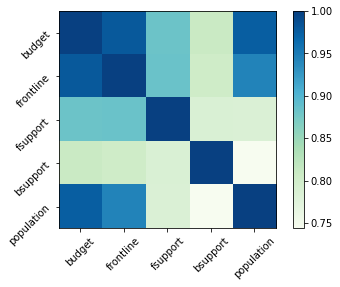

In [81]:
import matplotlib.pyplot as plt
%matplotlib inline 
plt.imshow(merged_good_no_london_subset.corr(), cmap=plt.cm.GnBu, interpolation='nearest',data=True)
plt.colorbar()
tick_marks = [i for i in range(len(merged_good_no_london_subset.columns))]
plt.xticks(tick_marks, merged_good_no_london_subset.columns, rotation=45)
plt.yticks(tick_marks, merged_good_no_london_subset.columns, rotation=45)